In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [6]:
features = ["Age", "Gender", "Total Bilirubin", "Direct Bilirubin", "Alkphos Alkaline Phosphotase", "Sgpt Alamine Aminotransferase", "Sgot Aspartate Aminotransferase", "Total Protiens", "Albumin", "Albumin-Globulin Ratio", "Selector"]
dataset = pd.read_csv('dataset.csv', names = features)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                                583 non-null int64
Gender                             583 non-null object
Total Bilirubin                    583 non-null float64
Direct Bilirubin                   583 non-null float64
Alkphos Alkaline Phosphotase       583 non-null int64
Sgpt Alamine Aminotransferase      583 non-null int64
Sgot Aspartate Aminotransferase    583 non-null int64
Total Protiens                     583 non-null float64
Albumin                            583 non-null float64
Albumin-Globulin Ratio             579 non-null float64
Selector                           583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [7]:
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(['Male','Female'])
dataset.loc[:,'Gender'] = labelEncoder.transform(dataset['Gender'])
dataset = dataset.dropna(how = 'any', axis = 0)
dataset['Selector'] = dataset['Selector'].map({2:0, 1:1})

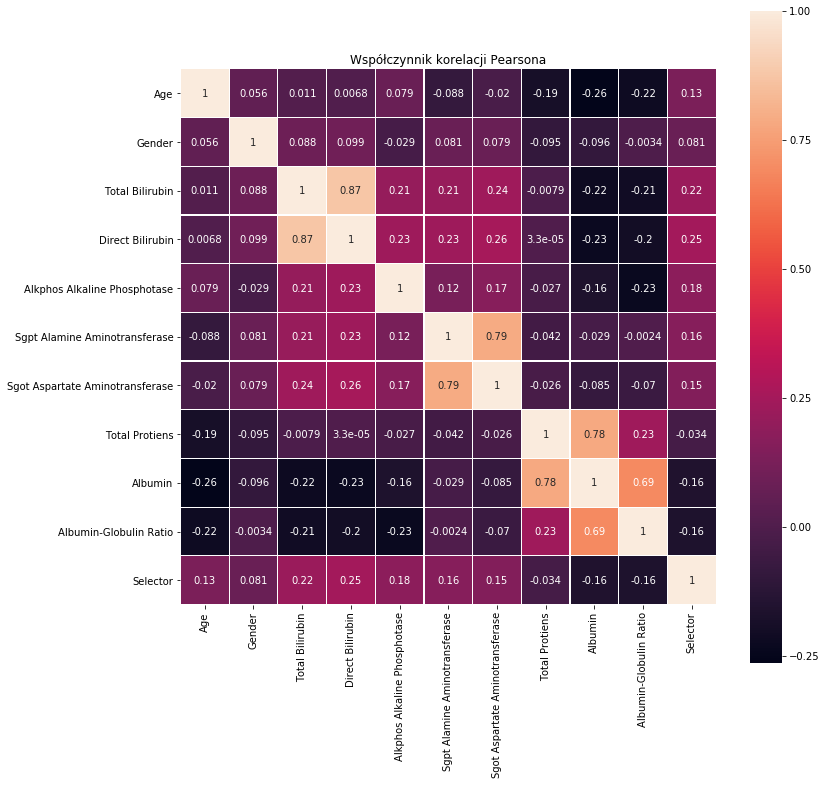

In [8]:
plt.subplots(figsize=(12, 12))
plt.title('Współczynnik korelacji Pearsona')
sns.heatmap(dataset.corr(),linewidths=0.25, vmax=1.0, square=True,annot=True)
plt.show()

In [9]:
X = dataset.drop('Selector', axis=1)
y = dataset.Selector

In [10]:
X_norm = MinMaxScaler().fit_transform(X)

/home/tomasz/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
from sklearn.feature_selection import SelectKBest, chi2

def get_k_best_features(X, y, k):
    X_dataframe = pd.DataFrame(X)
    selector = SelectKBest(chi2, k)
    selector.fit(X_dataframe, y)
    chi_support = selector.get_support()
    selected_features = X_dataframe.loc[:,chi_support]
    return selected_features

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# numberOfNeurons - type: tuple

def create_model(numberOfInputFeatures = 10, numberOfNeurons = (50,), learningRate = 0.03, momentum = 0):
    model = Sequential()
    model.add(Dense(numberOfNeurons[0], activation = 'relu', input_dim = numberOfInputFeatures))
    for layer in numberOfNeurons[1:]:
        model.add(Dense(layer, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
                    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    optimizer = SGD(lr=learningRate, momentum=momentum, decay=0.0, nesterov=False)
    model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [26]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

data = get_k_best_features(X_norm, y, 6)

model = KerasClassifier(build_fn=create_model,
                        nb_epoch=50,
                        batch_size=10,
                        numberOfNeurons=(10,20),
                        numberOfInputFeatures=6)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(model,data, y, cv=kfold)
print(results.mean())

Epoch 1/1
116/116 [==============================] - 3s 26ms/step
Epoch 1/1
116/116 [==============================] - 3s 24ms/step
Epoch 1/1
116/116 [==============================] - 3s 25ms/step
Epoch 1/1
116/116 [==============================] - 3s 28ms/step
Epoch 1/1
115/115 [==============================] - 3s 28ms/step
0.7132983554472988


In [27]:
from imblearn.over_sampling import SMOTE

cv = StratifiedKFold(n_splits=5, shuffle=True)

model = KerasClassifier(build_fn=create_model,
                        epochs=30,
                        batch_size=20,
                        numberOfNeurons=(20,20),
                        numberOfInputFeatures=6)

for fold, (train_idx, test_idx) in enumerate(cv.split(data, y), 1):
    X_train, y_train = data.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = data.iloc[test_idx], y.iloc[test_idx]
    X_train, y_train = SMOTE(sampling_strategy = 1.0).fit_sample(X_train, y_train)
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(data, y)}')

Epoch 1/30
662/662 [==============================] - 8s 12ms/step - loss: 0.6996 - acc: 0.4305
Epoch 2/30
662/662 [==============================] - 0s 481us/step - loss: 0.6946 - acc: 0.4804
Epoch 3/30
662/662 [==============================] - 0s 483us/step - loss: 0.6915 - acc: 0.5332
Epoch 4/30
662/662 [==============================] - 0s 338us/step - loss: 0.6896 - acc: 0.5755
Epoch 5/30
662/662 [==============================] - 0s 306us/step - loss: 0.6877 - acc: 0.5801
Epoch 6/30
662/662 [==============================] - 0s 390us/step - loss: 0.6858 - acc: 0.6012
Epoch 7/30
662/662 [==============================] - 0s 300us/step - loss: 0.6833 - acc: 0.5529
Epoch 8/30
662/662 [==============================] - 0s 366us/step - loss: 0.6804 - acc: 0.6480
Epoch 9/30
662/662 [==============================] - 0s 386us/step - loss: 0.6781 - acc: 0.6480
Epoch 10/30
662/662 [==============================] - 0s 321us/step - loss: 0.6765 - acc: 0.6571
Epoch 11/30
662/662 [=========

Epoch 23/30
662/662 [==============================] - 0s 307us/step - loss: 0.6394 - acc: 0.6767
Epoch 24/30
662/662 [==============================] - 0s 474us/step - loss: 0.6361 - acc: 0.6934
Epoch 25/30
662/662 [==============================] - 0s 356us/step - loss: 0.6329 - acc: 0.6949
Epoch 26/30
662/662 [==============================] - 0s 515us/step - loss: 0.6283 - acc: 0.7039
Epoch 27/30
662/662 [==============================] - 0s 439us/step - loss: 0.6251 - acc: 0.6903
Epoch 28/30
662/662 [==============================] - 0s 408us/step - loss: 0.6212 - acc: 0.7009
Epoch 29/30
662/662 [==============================] - 0s 390us/step - loss: 0.6172 - acc: 0.7009
Epoch 30/30
662/662 [==============================] - 0s 273us/step - loss: 0.6128 - acc: 0.7024
For fold 3:
579/579 [==============================] - 4s 6ms/step
Accuracy: 0.5664939555067678
Epoch 1/30
662/662 [==============================] - 9s 14ms/step - loss: 0.6878 - acc: 0.5816
Epoch 2/30
662/662 [====

In [ ]:
from sklearn.model_selection import GridSearchCV

numberOfNeurons= list(((i,i) for i in range(5, 100, 5)))
param_grid = dict(numberOfNeurons=numberOfNeurons)

kfold = StratifiedKFold(n_splits=4, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=kfold)
grid_result = grid.fit(data, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/home/tomasz/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/tomasz/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/tomasz/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/tomasz/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/extern

Epoch 1/1
579/579 [==============================] - 4s 8ms/step - loss: 0.6982 - acc: 0.4750
Best: 0.713299 using {'numberOfNeurons': (20, 20)}
0.514680 (0.158317) with: {'numberOfNeurons': (5, 5)}
0.592401 (0.144912) with: {'numberOfNeurons': (10, 10)}
0.607945 (0.155870) with: {'numberOfNeurons': (15, 15)}
0.713299 (0.003352) with: {'numberOfNeurons': (20, 20)}
0.682211 (0.055505) with: {'numberOfNeurons': (25, 25)}
0.626943 (0.066080) with: {'numberOfNeurons': (30, 30)}
0.645941 (0.081232) with: {'numberOfNeurons': (35, 35)}
0.656304 (0.056408) with: {'numberOfNeurons': (40, 40)}
0.578584 (0.154386) with: {'numberOfNeurons': (45, 45)}
0.675302 (0.043972) with: {'numberOfNeurons': (50, 50)}
0.649396 (0.087718) with: {'numberOfNeurons': (55, 55)}
0.680484 (0.048649) with: {'numberOfNeurons': (60, 60)}
0.645941 (0.107028) with: {'numberOfNeurons': (65, 65)}
0.621762 (0.105125) with: {'numberOfNeurons': (70, 70)}
0.675302 (0.034226) with: {'numberOfNeurons': (75, 75)}
0.696028 (0.03292